# Lab | API wrappers - Create your collection of songs & audio features

To move forward with the project, you need to create a collection of songs with their audio features - as large as possible! An idea for collecting as many songs as possible is to start with all the songs of a big, diverse playlist and then go to every artist present in the playlist and grab every song of every album of that artist. The amount of songs you'll be collecting per playlist will grow exponentially!


Spotify objects are identified by either a "url", a "uri" or an "id".

- The id is an alphanumeric code, and it's the nuclear part of the identifier.

- The uri contains "spotify:track" before the id. An uri is useful because it can be searched manually in the Spotify app.

- The url is a link to the song on the Spotify web player.

In [28]:
#!pip install spotipy

### Authentification

In [29]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentials
#sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='<your client id here>',
#                                                           client_secret='<your client secret here>'))

### Storing Secrets

In [30]:
secrets_file = open("/Users/gau82/Ironhack/Week6/6.5 API wrappers, Spotipy/secrets.txt","r")

In [31]:
string = secrets_file.read()

In [32]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        print(line.split(':'))
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

['cid', ' bccae7255f7b494ca17d15667489a8c1']
['csecret', ' 35c0fbac88034b30bb324f686e32fc59']


Authentication with Secrets

In [33]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['cid'],
                                                           client_secret=secrets_dict['csecret']))

# Handling large playlists

#### We will need to collect a "database" of songs. Playlists are a good way to access relatively large amounts of songs.

In [34]:
# we will need more songs for our clustering
playlist = sp.user_playlist_tracks("spotify", "1G8IpkZKobrIlXcVPoSIuf")

In [35]:
playlist["total"]

10000

In [36]:
len(playlist["items"])

100

### Function to extract all songs from a playlist

In [37]:
playlist['next']

'https://api.spotify.com/v1/playlists/1G8IpkZKobrIlXcVPoSIuf/tracks?offset=100&limit=100&additional_types=track'

In [ ]:
#sp.next(playlist)

In [39]:
from random import randint
from time import sleep

def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = results['items']
    while results['next']!=None:
        results = sp.next(results)
        tracks = tracks + results['items']
        sleep(randint(1,3000)/1000) # respectful nap
    return tracks

In [40]:
#this now holds all 10,000 songs and their artists
#need to make it into a dataframe, once we've broken it down! 

all_tracks = get_playlist_tracks("1G8IpkZKobrIlXcVPoSIuf")
len(all_tracks)

10000

##### Method1: we ONLY need artist, name of song, and URI for the database

In [ ]:
# all_tracks

In [90]:
all_tracks[0]['track']['uri']

'spotify:track:3AhXZa8sUQht0UEdBJgpGc'

In [42]:
all_tracks[0]['track']['artists'][0]['name']

'Bob Dylan'

In [43]:
all_tracks[0]['track']['name']

'Like a Rolling Stone'

In [44]:
all_tracks[0]['track']['uri']

'spotify:track:3AhXZa8sUQht0UEdBJgpGc'

### Method2: Getting the artist, song name, and URI from each song of my playlist

In [45]:
# #first we need to get a list of individual tracks from the playlist
# def get_name_artist_from_playlist_item(playlist_item):
#     return get_name_artists_from_track(playlist_item['track'])

In [46]:
# get_name_artist_from_playlist_item(results["items"][0])

In [47]:
# def get_name_artists_from_playlist(input_playlist):
#     return list(map(get_name_artist_from_playlist_item,input_playlist["items"]))

In [48]:
# get_name_artists_from_playlist(playlist)

In [49]:
# def get_name_artists_from_playlist(input_playlist):
#     return flatten(list(map(get_name_artist_from_playlist_item,input_playlist["items"])))

In [50]:
# df = get_name_artists_from_playlist(results)

#### Creating a Dataframe: 

In [51]:
# use a "for" loop to get the audio features, artists, and song names of all 10,000 songs in the playlist and
# put them inside the lists, making sure to ignore the Nans

In [52]:
#creating lists to hold song, artist, uri

song_name = []   
artist_name = []
track_uri = []


for i in range(len(all_tracks)):
    try:
        song = all_tracks[i]['track']['name']
        artist = all_tracks[i]["track"]["album"]['artists'][0]['name']
        uri = all_tracks[i]['track']['uri']
        
        artist_name.append(artist)
        song_name.append(song)
        track_uri.append(uri)
    except:
        artist_name.append('none')
        song_name.append('none')
        track_uri.append('none')

In [54]:
import pandas as pd

spotify_df=pd.DataFrame({'song': song_name,'artist': artist_name,'uri': track_uri})

In [94]:
spotify_df.head()

,song,artist,uri
0,Like a Rolling Stone,Bob Dylan,spotify:track:3AhXZa8sUQht0UEdBJgpGc
1,Smells Like Teen Spirit,Nirvana,spotify:track:3oTlkzk1OtrhH8wBAduVEi
2,A Day In The Life - Remastered,The Beatles,spotify:track:3ZFBeIyP41HhnALjxWy1pR
3,Good Vibrations (Mono),The Beach Boys,spotify:track:5Qt4Cc66g24QWwGP3YYV9y
4,Johnny B Goode,Chuck Berry,spotify:track:7MH2ZclofPlTrZOkPzZKhK


In [ ]:
spotify_df.song.value_counts()
spotify_df
#can see there are 53 "nones"

In [ ]:
spotify_df.artist.value_counts()

In [ ]:
# spotify_df.isna().sum()
sum(spotify_df.duplicated())

In [202]:
spotify_df.to_csv('spotify_df.csv', index=False)

# Audio features

In [96]:
# get the uri of a single song:
song_uri = all_tracks[0]['track']['uri']
song_uri

'spotify:track:3AhXZa8sUQht0UEdBJgpGc'

In [57]:
# get the audio features for that song
sp.audio_features(song_uri)

[{'danceability': 0.63,
  'energy': 0.616,
  'key': 1,
  'loudness': -8.128,
  'mode': 0,
  'speechiness': 0.0309,
  'acousticness': 0.463,
  'instrumentalness': 0.0408,
  'liveness': 0.173,
  'valence': 0.509,
  'tempo': 118.65,
  'type': 'audio_features',
  'id': '1dv3ePjze9tPq2pk8eWJdR',
  'uri': 'spotify:track:1dv3ePjze9tPq2pk8eWJdR',
  'track_href': 'https://api.spotify.com/v1/tracks/1dv3ePjze9tPq2pk8eWJdR',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1dv3ePjze9tPq2pk8eWJdR',
  'duration_ms': 270773,
  'time_signature': 4}]

In [74]:
song_uri1 = playlist["items"][50]["track"]["uri"]
song_uri1

'spotify:track:13KEdaWIc7T6ozEmnJjHy1'

In [75]:
# get the audio features for that song
list1 = sp.audio_features(song_uri1)

In [95]:
%%time
list_af = []
for x in spotify_df['uri']:
    song = sp.audio_features(x)
    list_af.append(song)

In [107]:
spotify_af = pd.DataFrame(list_af)
# spotify_af.reset_index(inplace=True)
spotify_af.columns = ['features']
spotify_af

,features
0,"{'danceability': 0.482, 'energy': 0.721, 'key'..."
1,"{'danceability': 0.485, 'energy': 0.863, 'key'..."
2,"{'danceability': 0.364, 'energy': 0.457, 'key'..."
3,"{'danceability': 0.398, 'energy': 0.413, 'key'..."
4,"{'danceability': 0.518, 'energy': 0.756, 'key'..."
...,...
9995,"{'danceability': 0.332, 'energy': 0.707, 'key'..."
9996,"{'danceability': 0.464, 'energy': 0.749, 'key'..."
9997,"{'danceability': 0.694, 'energy': 0.71, 'key':..."
9998,"{'danceability': 0.332, 'energy': 0.8, 'key': ..."


In [99]:
def flatten(data, col_list):
    for column in col_list:
        flattened = pd.DataFrame(dict(data[column])).transpose()
        columns = [str(col) for col in flattened.columns]
        flattened.columns = [column + '_' + colname for colname in columns]
        data = pd.concat([data, flattened], axis=1)
        data = data.drop(column, axis=1)
    return data

In [108]:
spotify_df1 = flatten(spotify_af,['features'])

In [155]:
spotify_df1.head(5)

,features_danceability,features_energy,features_key,features_loudness,features_mode,features_speechiness,features_acousticness,features_instrumentalness,features_liveness,features_valence,features_tempo,features_type,features_id,features_uri,features_track_href,features_analysis_url,features_duration_ms,features_time_signature
0,0.482,0.721,0,-6.839,1,0.0321,0.731,0,0.189,0.557,95.263,audio_features,3AhXZa8sUQht0UEdBJgpGc,spotify:track:3AhXZa8sUQht0UEdBJgpGc,https://api.spotify.com/v1/tracks/3AhXZa8sUQht...,https://api.spotify.com/v1/audio-analysis/3AhX...,369600,4
1,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.0162,0.138,0.767,116.835,audio_features,3oTlkzk1OtrhH8wBAduVEi,spotify:track:3oTlkzk1OtrhH8wBAduVEi,https://api.spotify.com/v1/tracks/3oTlkzk1Otrh...,https://api.spotify.com/v1/audio-analysis/3oTl...,300977,4
2,0.364,0.457,4,-14.162,0,0.0675,0.29,0.000106,0.922,0.175,163.219,audio_features,3ZFBeIyP41HhnALjxWy1pR,spotify:track:3ZFBeIyP41HhnALjxWy1pR,https://api.spotify.com/v1/tracks/3ZFBeIyP41Hh...,https://api.spotify.com/v1/audio-analysis/3ZFB...,337413,4
3,0.398,0.413,1,-10.934,1,0.0388,0.0822,0.000025,0.0891,0.331,133.574,audio_features,5Qt4Cc66g24QWwGP3YYV9y,spotify:track:5Qt4Cc66g24QWwGP3YYV9y,https://api.spotify.com/v1/tracks/5Qt4Cc66g24Q...,https://api.spotify.com/v1/audio-analysis/5Qt4...,219147,4
4,0.518,0.756,10,-10.851,1,0.0915,0.735,0.000062,0.317,0.968,166.429,audio_features,7MH2ZclofPlTrZOkPzZKhK,spotify:track:7MH2ZclofPlTrZOkPzZKhK,https://api.spotify.com/v1/tracks/7MH2ZclofPlT...,https://api.spotify.com/v1/audio-analysis/7MH2...,160893,4


In [113]:
spotify_df1.columns
spotify_df1.dtypes
spotify_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   features_danceability      9947 non-null   object
 1   features_energy            9947 non-null   object
 2   features_key               9947 non-null   object
 3   features_loudness          9947 non-null   object
 4   features_mode              9947 non-null   object
 5   features_speechiness       9947 non-null   object
 6   features_acousticness      9947 non-null   object
 7   features_instrumentalness  9947 non-null   object
 8   features_liveness          9947 non-null   object
 9   features_valence           9947 non-null   object
 10  features_tempo             9947 non-null   object
 11  features_type              9947 non-null   object
 12  features_id                9947 non-null   object
 13  features_uri               9947 non-null   object
 14  feature

In [174]:
# Dropping all categorical column(s): I just tried to kept those columns which has numbers in it and dropped others !!
# I dropped features_duration_ms beacuse the values were far too high when compared to other features !!

spotify_df1_num = spotify_df1.drop(['features_type', 'features_id','features_uri', 'features_track_href', 'features_analysis_url', 'features_time_signature', 'features_duration_ms'], axis=1)

In [175]:
spotify_df1_num.head(5)
# spotify_df1_num.isna().sum()
# spotify_df1_num.shape

,features_danceability,features_energy,features_key,features_loudness,features_mode,features_speechiness,features_acousticness,features_instrumentalness,features_liveness,features_valence,features_tempo
0,0.482,0.721,0,-6.839,1,0.0321,0.731,0,0.189,0.557,95.263
1,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.0162,0.138,0.767,116.835
2,0.364,0.457,4,-14.162,0,0.0675,0.29,0.000106,0.922,0.175,163.219
3,0.398,0.413,1,-10.934,1,0.0388,0.0822,0.000025,0.0891,0.331,133.574
4,0.518,0.756,10,-10.851,1,0.0915,0.735,0.000062,0.317,0.968,166.429


In [176]:
spotify_df1_num=spotify_df1_num.dropna()

In [203]:
spotify_df1.to_csv('spotify_df1.csv', index=False)

# Unsupervised Machine Learning Lab | Clustering

It's the moment to perform clustering on the songs you collected.

Remember that the ultimate goal of this little project is to improve the recommendations of artists.

Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs

that belong to the same cluster - songs with similar audio features.

In [148]:
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

In [177]:
# numericals = df.select_dtypes(include= np.number)
# df.astype()

for i in spotify_df1_num.columns:
    spotify_df1_num[i]=pd.to_numeric(spotify_df1_num[i],errors='coerce')

In [178]:
spotify_df1_num.describe().T

,count,mean,std,min,25%,50%,75%,max
features_danceability,9947.0,0.565515,0.166720,0.06920,0.451000,0.568000,0.6850,0.988
features_energy,9947.0,0.616766,0.233720,0.00002,0.450500,0.651000,0.8090,0.998
features_key,9947.0,5.291344,3.542447,0.00000,2.000000,5.000000,9.0000,11.000
features_loudness,9947.0,-9.201051,3.860815,-60.00000,-11.578000,-8.652000,-6.3230,1.342
features_mode,9947.0,0.707651,0.454865,0.00000,0.000000,1.000000,1.0000,1.000
features_speechiness,9947.0,0.071016,0.074831,0.02260,0.033500,0.043300,0.0702,0.934
features_acousticness,9947.0,0.307054,0.324787,0.00000,0.023400,0.167000,0.5635,0.996
features_instrumentalness,9947.0,0.106171,0.239799,0.00000,0.000002,0.000315,0.0297,0.993
features_liveness,9947.0,0.189562,0.153861,0.00829,0.091700,0.129000,0.2460,0.993
features_valence,9947.0,0.576938,0.246165,0.03270,0.383500,0.592000,0.7800,0.988


In [179]:
# The scale of "duration_ms" is much higher than the scale of many other variables!
# K-Means is a distance based algorithm: we need to scale / normalize:

X_prep = StandardScaler().fit_transform(spotify_df1_num)

# scaler = StandardScaler().fit(audio_features)


# Now, all features will have the same weight.
pd.DataFrame(X_prep,columns=spotify_df1_num.columns).head()

#here we have using standardscaler, but we should also try it with min/max scaler to see results

,features_danceability,features_energy,features_key,features_loudness,features_mode,features_speechiness,features_acousticness,features_instrumentalness,features_liveness,features_valence,features_tempo
0,-0.500954,0.446000,-1.493772,0.611832,0.642749,-0.520076,1.305372,-0.442774,-0.003653,-0.080997,-0.932501
1,-0.482958,1.053596,-1.211468,0.045084,0.642749,-0.287541,-0.945410,-0.375214,-0.335138,0.772132,-0.160931
2,-1.208762,-0.683616,-0.364553,-1.285013,-1.555816,-0.046987,-0.052510,-0.442332,4.760625,-1.632878,1.498095
3,-1.004817,-0.871885,-1.211468,-0.448878,0.642749,-0.430537,-0.692346,-0.442668,-0.652973,-0.999125,0.437776
4,-0.285012,0.595760,1.329277,-0.427379,0.642749,0.273752,1.317688,-0.442515,0.828308,1.588697,1.612908


### Choosing K

#### Elbow Method
so we've built 7 models here (with K ranging between 2 and 9)

doesn't yield a very clear optimal k, looks at 5 or 6

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

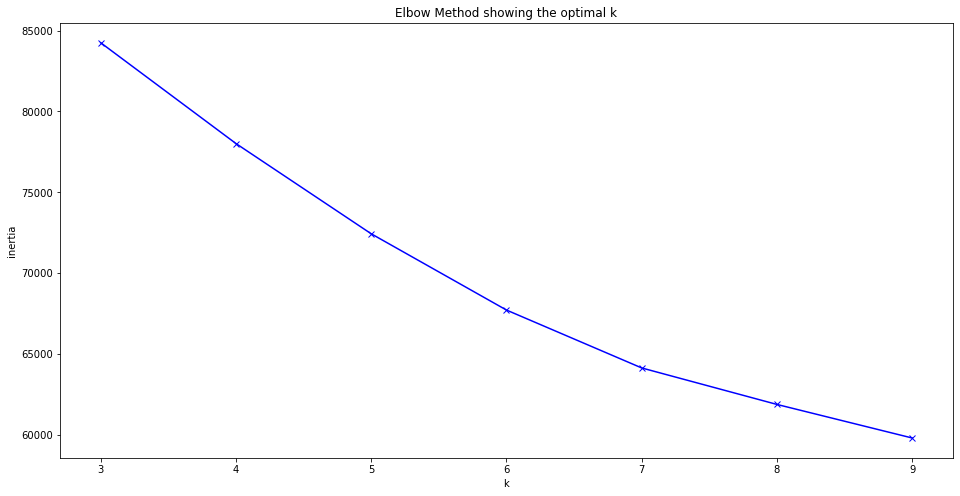

In [182]:
import numpy as np
K = range(3, 10)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

### Silhouette score

in silhouette score, the higher score the better

I prefer to choose optimal k-value as 7

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

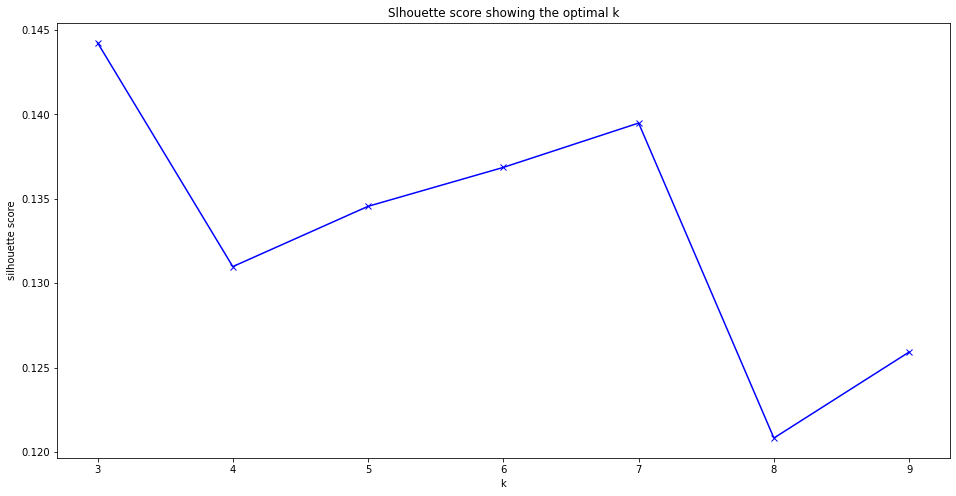

In [183]:
from sklearn.metrics import silhouette_score
K = range(3, 10)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

### I choose 7 clusters

In [196]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=1234)
kmeans.fit(X_prep)

KMeans(n_clusters=7, random_state=1234)

In [185]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_prep)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    2497
1    1694
2     921
3    1967
4    1681
5     609
6     578
dtype: int64

In [186]:
clusters   #this is now an array of all the songs assigned a cluster 

array([0, 0, 6, ..., 5, 1, 0])

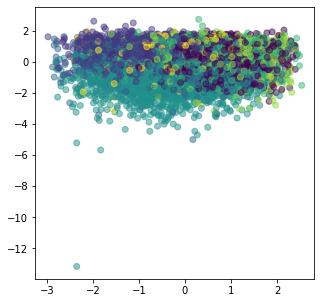

In [187]:
# Plotting first column with 4th 
# visualizing column 0 and column 4

# plt.figure(figsize=(5, 5))
# plt.scatter(X_prep[:, 0], X_prep[:, 3], c=clusters,alpha=0.5) #visualizing column 0 and column 4
# plt.show()

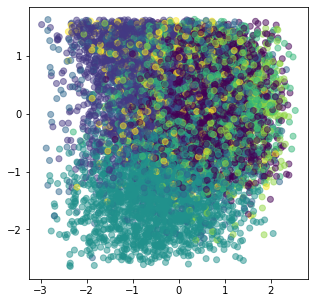

In [188]:
#Plotting first column with 2nd

# plt.figure(figsize=(5, 5))
# plt.scatter(X_prep[:, 0], X_prep[:, 1], c=clusters,alpha=0.5) #visualizing column 0 and column 2
# plt.show()

In [189]:
# With k = 7, the intertia scores are very close. 
# Instruction given: don’t waste time on parameters /number of clusters for now - use defaults

kmeans.inertia_ 

64126.297889198875

In [191]:
kmeans = KMeans(n_clusters=7,
                init="random",
                n_init=100,
                max_iter=10,
                tol=0,
                random_state=69)
kmeans.fit(X_prep)
print(kmeans.inertia_)

64134.07807255264


### Concatenating the file (audio features + artists + songs)

In [193]:
spotify_concat = pd.concat([spotify_df, spotify_df1_num], axis=1)

In [ ]:
spotify_concat.head(5)

In [199]:
spotify_concat=spotify_concat.dropna()

#### 1. Cluster the songs you collected:
- scale the audio features of your songs. this should create an object called scaler  (store it, you’re gonna need it in the future) and an array with 
scaled features, let’s call it X_scaled
- this process should only be done once, not every time a song is inputed! However, you are going to need the clustered dataframe X , the scaler, 
and the kmeans model to be loaded in your environment (i.e. notebook) when the user inputs a song. Tip: consider doing this through creating a module and loading it from another notebook.

In [192]:
# initialize a KMeans model with kmeans = KMeans(random_state=1234)
# (don’t waste time on parameters /number of clusters for now - use defaults!)
# fit the model to your data using kmeans.fit(X_scaled)

kmeans = KMeans(random_state=1234)

In [200]:
# create a column called cluster in your original dataframe, with the assigned cluster, 
# using X["cluster"] = kmeans.predict(input_song)

spotify_concat["cluster"] = kmeans.predict(X_prep)

C:\Users\gau82\AppData\Local\Temp\ipykernel_12440\2943770794.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_concat["cluster"] = kmeans.predict(X_prep)


In [201]:
spotify_concat.head(4)

,song,artist,uri,features_danceability,features_energy,features_key,features_loudness,features_mode,features_speechiness,features_acousticness,features_instrumentalness,features_liveness,features_valence,features_tempo,cluster
0,Like a Rolling Stone,Bob Dylan,spotify:track:3AhXZa8sUQht0UEdBJgpGc,0.482,0.721,0.0,-6.839,1.0,0.0321,0.731000,0.000000,0.1890,0.557,95.263,0
1,Smells Like Teen Spirit,Nirvana,spotify:track:3oTlkzk1OtrhH8wBAduVEi,0.485,0.863,1.0,-9.027,1.0,0.0495,0.000012,0.016200,0.1380,0.767,116.835,0
2,A Day In The Life - Remastered,The Beatles,spotify:track:3ZFBeIyP41HhnALjxWy1pR,0.364,0.457,4.0,-14.162,0.0,0.0675,0.290000,0.000106,0.9220,0.175,163.219,6
3,Good Vibrations (Mono),The Beach Boys,spotify:track:5Qt4Cc66g24QWwGP3YYV9y,0.398,0.413,1.0,-10.934,1.0,0.0388,0.082200,0.000025,0.0891,0.331,133.574,1


In [204]:
spotify_concat.to_csv('spotify_concat.csv', index=False)